### This is an example notebook to show how to get significant features from the hyperspectral images for use in linear regression

In [52]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import sys

After importing all the necessary modules, need to add the utilites folder to the sys.path

In [53]:
sys.path.append("../HyperUnmixing")
#from HyperUnmixing import pca_util as pca
from pca_util import get_PC

IMG_PATH = 'C:/Users/Preetham/Desktop/image1.npy'

Load the image. Change the IMG_PATH to the location where image is stored.

In [54]:
im = np.load(IMG_PATH)
im.shape

(256, 256, 1128)

Each pixel in the image has a depth of 1128 layers, that is each pixel is a spectrum as shown below.

Text(0.5, 1.0, 'Depth of the pixel at (100,100)')

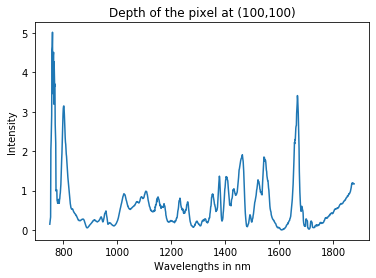

In [55]:
plt.plot(750 + np.arange(im.shape[2]), im[100,100,:])
plt.xlabel('Wavelengths in nm')
plt.ylabel('Intensity')
plt.title("Depth of the pixel at (100,100)")

`get_PC` function from the pca_util file in HyperUnmixing package can be used to do Principle Component Analysis on the image. The function considers each pixel independent, and takes the 1128 wavelengths in the depth of each pixel as features. PCA is done on these to get the their loading scores (or coefficients) in each PC.

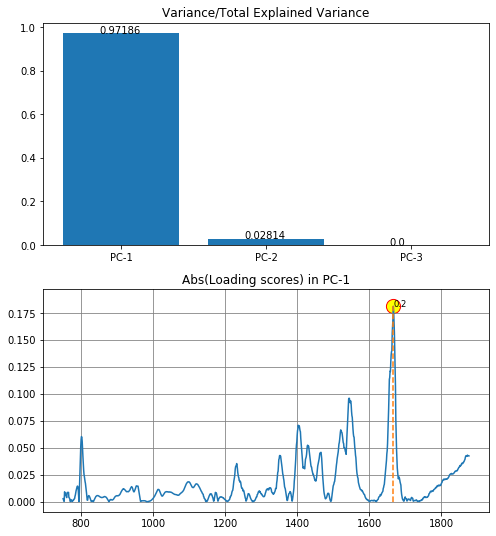

In [56]:
loading_scores = get_PC(im, show_plots=True, top_n=3, PC_n=1, top_load_n=1, figsize=(8,9))

Once the loading scores are obtained, just PC-1 and PC-2 can be taken as features to predict new hyperspectral images.
Since pixels in the image are obtained by independent Photoinduced AFM measurements, the same image can be split into an x-image and a y-image with different pixels as shown below.

### The Goal is to see if we can predict y-image from x-image

In [67]:
#Train data
im_x = im[:100, :100, :]
im_y = im[100:200, 100:200, :]

#reshaping im_x and im_y required for use in LinearRegression functions
im_x_flat = np.reshape(im_x, (im_x.shape[0]*im_x.shape[1], im_x.shape[2]))
im_y_flat = np.reshape(im_y, (im_y.shape[0]*im_y.shape[1], im_y.shape[2]))

#-------------------------------
#Test data
im_x_test = im[100:200, :100, :]
im_y_test = im[:100, 100:200, :]

#reshaping im_x and im_y required for use in LinearRegression functions
im_x_test_flat = np.reshape(im_x_test, (im_x_test.shape[0]*im_x_test.shape[1], im_x_test.shape[2]))
im_y_test_flat = np.reshape(im_y_test, (im_y_test.shape[0]*im_y_test.shape[1], im_y_test.shape[2]))

The function generates a single feature from linear combination of 1128 features in each pixel. The loading scores from nth PCA will be used as the coefficients.

In [68]:
def make_PC_feats(im_x, loading_scores, PC_num=[1]):
    """
    Makes single feature using loading scores of PC_num^th PC, by linear combination of features in im_x

    Parameters
    ----------
    im_x : image passed as numpy array
    loading_scores : numpy array with ith row should have loading scores of ith PC.
    PC_num : if PC_num = n, then nth PC's loading scores will be used to calculate the new feature

    Returns
    -------
    out : ndarray
        A new x array, with PC as feature in a single column

    """
    new_im_x = np.reshape(np.dot(im_x, loading_scores[PC_num[0]-1]),(-1,1))
    if len(PC_num)>1:
        for PC in PC_num[1:]:
            new_im_x = np.hstack([new_im_x, np.reshape(np.dot(im_x, loading_scores[PC-1]),(-1,1))])

    return new_im_x

Now I use a Linear Regression model from sklearn to see if the 1st principle component can be used to predict one part of image from another.

In [74]:
new_im_x = make_PC_feats(im_x_flat, loading_scores, PC_num=[1])
new_im_x_test = make_PC_feats(im_x_test_flat, loading_scores, PC_num=[1])

new_im_y = make_PC_feats(im_y_flat, loading_scores, PC_num=[1])
new_im_y_test = make_PC_feats(im_y_test_flat, loading_scores, PC_num=[1])


lin_reg = LinearRegression()
lin_reg.fit(new_im_x, new_im_y)
lin_coeffs = lin_reg.coef_
lin_interc = lin_reg.intercept_
lin_score = round(lin_reg.score(new_im_x_test, new_im_y_test),3)
lin_pred = lin_reg.predict(new_im_x)

print(lin_score)

-0.116


$R^2$ value is very low (even less than zero), which implies that the model is unable to predict image-y well from image-x

In [75]:
PC_im_x = new_im_x.reshape(im_x.shape[:2])
PC_im_y = new_im_y.reshape(im_y.shape[:2])
pred_y = lin_pred.reshape(im_y.shape[:2])

Text(0.5, 1.0, 'PC image : prediction from Train x')

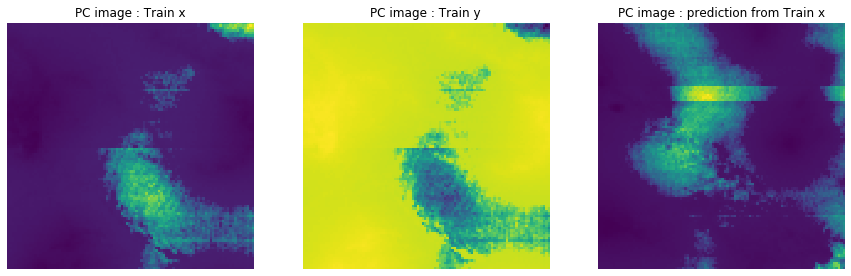

In [76]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))

for a in ax:
    a.axis('off')
    
ax[0].imshow(PC_im_x)
ax[0].set_title("PC image : Train x")

ax[1].imshow(pred_y)
ax[1].set_title("PC image : Train y")

ax[2].imshow(PC_im_y)
ax[2].set_title("PC image : prediction from Train x")

The prediction did not end up as expected. It turns out that PCs alone cannot be used as single feature for prediction for one image from another. Or maybe the PCs could be different locally, compared to the global PCs. We are testing out different methods like this to see if there is any correlation between these pixels. All these images are obtained from semiconductor-polymer mixtures. If there is a correlation between pixels, then such spectral images can be used to predict compositions of samples using the spectra of pure samples as ground truths. 